In [2]:
import os
os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/RA2_alpine_lads/ra_joint_predictions')

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [43]:
info_folder = "~/ra_challenge/RA_challenge/michael_dev/RA2_alpine_lads/trained_models/"
ground_truth = "/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv"

v1_output = info_folder+"output_v1_val.csv" # 0.8062 narrowing = 0.6135 erosion = 1.2509

v2_output = info_folder+"output_v2_sgd.csv" # 1.4157 narrowing = 1.0169 erosion = 1.7587

In [44]:
ground_truth_df = pd.read_csv(ground_truth)
v1_output_df = pd.read_csv(v1_output)
v2_output_df = pd.read_csv(v2_output)

In [114]:
ground_truth_df

,Patient_ID,Overall_Tol,Overall_erosion,Overall_narrowing,LH_mcp_E__ip,LH_pip_E__2,LH_pip_E__3,LH_pip_E__4,LH_pip_E__5,LH_mcp_E__1,...,LF_mtp_J__2,LF_mtp_J__3,LF_mtp_J__4,LF_mtp_J__5,RF_mtp_J__ip,RF_mtp_J__1,RF_mtp_J__2,RF_mtp_J__3,RF_mtp_J__4,RF_mtp_J__5
0,UAB001,45,2,43,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,2
1,UAB002,2,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,UAB003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,UAB005,6,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,UAB006,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,UAB716,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
364,UAB717,20,0,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
365,UAB719,25,1,24,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
366,UAB720,35,6,29,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
def overall_plot(truth,sample, what = "Tol"):
    a=sample[["Patient_ID","Overall_Tol","Overall_erosion","Overall_narrowing"]].merge(truth[["Patient_ID","Overall_Tol","Overall_erosion","Overall_narrowing"]],how="inner",on = "Patient_ID")
    fig, ax = plt.subplots()
    sns.scatterplot(data = a, x = f"Overall_{what}_x", y = f"Overall_{what}_y")
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.ylabel("ground truth")
    plt.ylim((-5,250))
    plt.xlim((-5,250))
    fig.set_size_inches(5, 5)
    
def calculate_error(truth,sample, what = "Tol"):
    a=sample[["Patient_ID","Overall_Tol","Overall_erosion","Overall_narrowing"]].merge(truth[["Patient_ID","Overall_Tol","Overall_erosion","Overall_narrowing"]],how="inner",on = "Patient_ID")
    return mean_absolute_error(a[f"Overall_{what}_x"], a[f"Overall_{what}_y"])

def per_joint_error(truth,sample, what = "LH_mcp_E__ip"):
    a=sample[["Patient_ID",what]].merge(truth[["Patient_ID",what]],how="inner",on = "Patient_ID")
    return mean_absolute_error(a[f"{what}_x"], a[f"{what}_y"])

def per_joint_error_excluding_0(truth,sample, what = "LH_mcp_E__ip"):
    a=sample[["Patient_ID",what]].merge(truth[["Patient_ID",what]],how="inner",on = "Patient_ID")
    return mean_absolute_error(a.loc[a[f"{what}_y"] != 0,f"{what}_x"], a.loc[a[f"{what}_y"] != 0,f"{what}_y"])

def per_joint_error_only_0(truth,sample, what = "LH_mcp_E__ip"):
    a=sample[["Patient_ID",what]].merge(truth[["Patient_ID",what]],how="inner",on = "Patient_ID")
    plt.hist(a.loc[a[f"{what}_y"] == 0,f"{what}_x"],range=(0,5))
    plt.show()
    return mean_absolute_error(a.loc[a[f"{what}_y"] == 0,f"{what}_x"], a.loc[a[f"{what}_y"] == 0,f"{what}_y"])

In [175]:
calculate_error(ground_truth_df,v1_output_df,"narrowing")

5.489777750587195

In [176]:
calculate_error(ground_truth_df,v2_output_df,"narrowing")

9.425503558467438

In [178]:
for joint in ground_truth_df.columns[4:]:
    print(joint,per_joint_error_excluding_0(ground_truth_df,v1_output_df,joint),per_joint_error_excluding_0(ground_truth_df,v2_output_df,joint))

LH_mcp_E__ip 1.9993948401718056 1.7971145267352278
LH_pip_E__2 1.6660490115195892 1.0251915384492376
LH_pip_E__3 2.236344915408271 1.3366354123484325
LH_pip_E__4 2.7432779276279144 1.5775695576681756
LH_pip_E__5 2.998922427298826 2.046918848558562
LH_mcp_E__1 2.1348175321376366 1.446897761878251
LH_mcp_E__2 2.2828351595036414 1.2574774779001632
LH_mcp_E__3 2.2238538439194926 1.3556424632036699
LH_mcp_E__4 1.4982661738002883 1.271768658263835
LH_mcp_E__5 3.7997313893685893 2.780861673621443
LH_wrist_E__mc1 1.2495733580677728 0.7560115629934491
LH_wrist_E__mul 1.9093180916403365 1.6653801906067365
LH_wrist_E__nav 2.44517221493246 1.2995176035285594
LH_wrist_E__lunate 2.4572200415496344 2.1046887721552263
LH_wrist_E__radius 3.1498965465140656 2.2851925106626916
LH_wrist_E__ulna 3.1347115827084466 2.835050748546778
RH_mcp_E__ip 2.9999904852155623 2.386464648647234
RH_pip_E__2 2.249635189181654 1.589562753785458
RH_pip_E__3 1.454036987213071 1.3204943125104667
RH_pip_E__4 2.499617004158269 

In [121]:
per_joint_error(ground_truth_df,v1_output_df,"LH_mcp_E__ip")

0.06524683304319272

In [122]:
per_joint_error(ground_truth_df,v2_output_df,"LH_mcp_E__ip")

0.143679713703264

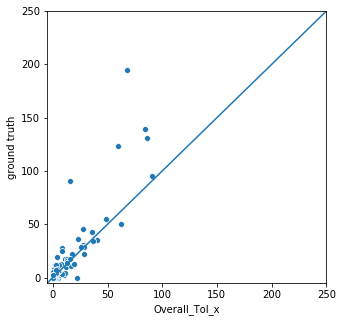

In [109]:
overall_plot(ground_truth_df,v1_output_df,"Tol")

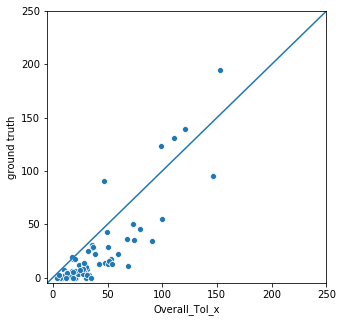

In [93]:
overall_plot(ground_truth_df,v2_output_df,"Tol")